In [2]:
import numpy as np
from triangle import triangle
from model import *
from netCDF4 import Dataset
from InterpFromGridToMesh import InterpFromGridToMesh
from bamg import bamg
from xy2ll import xy2ll
from plotmodel import plotmodel
from export_netCDF import export_netCDF
from loadmodel import loadmodel
from setmask import setmask
from parameterize import parameterize
from setflowequation import setflowequation
from socket import gethostname
from solve import solve
from ll2xy import ll2xy
from BamgTriangulate import BamgTriangulate
from InterpFromMeshToMesh2d import InterpFromMeshToMesh2d
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

   Step 1: Mesh creation
Anisotropic mesh adaptation

   new number of triangles = 6345
File ./Models/Greenland.Mesh_generation.nc allready exist


Give a new name or "delete" to replace:  delete


field md.solidearth.external is None
qmu is skipped until it is more stable


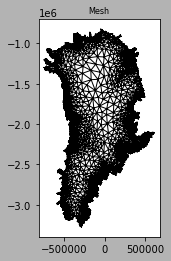

In [3]:
steps = [1]

if 1 in steps:
    # Step 1: Mesh creation {{{
    print('   Step 1: Mesh creation')

    #Generate initial uniform mesh (resolution = 20000 m)
    md = triangle(model(), './DomainOutline.exp', 20000)

    ncdata = Dataset('./Data/Greenland_5km_dev1.2.nc', mode='r')

    # Get velocities (Note: You can use ncprint('file') to see an ncdump)
    x1 = np.squeeze(ncdata.variables['x1'][:].data)
    y1 = np.squeeze(ncdata.variables['y1'][:].data)
    velx = np.squeeze(ncdata.variables['surfvelx'][:].data)
    vely = np.squeeze(ncdata.variables['surfvely'][:].data)
    ncdata.close()

    vx = InterpFromGridToMesh(x1, y1, velx, md.mesh.x, md.mesh.y, 0)
    vy = InterpFromGridToMesh(x1, y1, vely, md.mesh.x, md.mesh.y, 0)
    vel = np.sqrt(vx**2 + vy**2)

    #Mesh Greenland
    md = bamg(md, 'hmax', 400000, 'hmin', 5000, 'gradation', 1.4, 'field', vel, 'err', 8)

    #convert x, y coordinates (Polar stereo) to lat / lon
    [md.mesh.lat, md.mesh.long] = xy2ll(md.mesh.x, md.mesh.y, + 1, 39, 71)

    export_netCDF(md, './Models/Greenland.Mesh_generation.nc')
    plotmodel(md, 'data', 'mesh')


In [4]:
steps = [2]

if 2 in steps:
    #  Step 2: Parameterization{{{
    print('   Step 2: Parameterization')
    md = loadmodel('./Models/Greenland.Mesh_generation.nc')

    md = setmask(md, '', '')
    md = parameterize(md, './Greenland.py')
    md = setflowequation(md, 'SSA', 'all')

    export_netCDF(md, "./Models/Greenland.Parameterization.nc")


   Step 2: Parameterization
Opening ./Models/Greenland.Mesh_generation.nc for reading 
group results is empty
   Loading SeaRISE data from NetCDF
   Interpolating surface and bedrock
   Constructing thickness
   Interpolating velocities 
   Interpolating temperatures
   Interpolating surface mass balance
   Construct basal friction parameters
   Construct ice rheological properties
   Set other boundary conditions
   Set geothermal heat flux
   Set Pressure
   Single point constraints
File ./Models/Greenland.Parameterization.nc allready exist


Give a new name or "delete" to replace:  delete


field md.solidearth.external is None
qmu is skipped until it is more stable


Opening ./Models/Greenland.Parameterization.nc for reading 
group results is empty


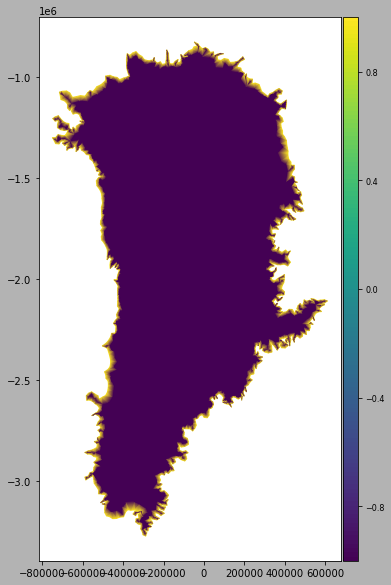

In [5]:
md = loadmodel('./Models/Greenland.Parameterization.nc')

fig = plt.figure(figsize=(10,10))
plotmodel(md, 'data', md.mask.ice_levelset)


In [6]:
steps = [3]

if 3 in steps:
    #   Step 3: Control method friction {{{
    print('   Step 3: Control method friction')
    md = loadmodel('./Models/Greenland.Parameterization.nc')
    #Control general
    md.inversion.iscontrol = 1
    md.inversion.nsteps = 30
    md.inversion.step_threshold = 0.99 * np.ones((md.inversion.nsteps))
    md.inversion.maxiter_per_step = 5 * np.ones((md.inversion.nsteps))

    #Cost functions
    md.inversion.cost_functions = [101, 103, 501]
    md.inversion.cost_functions_coefficients = np.ones((md.mesh.numberofvertices, 3))
    md.inversion.cost_functions_coefficients[:, 0] = 350
    md.inversion.cost_functions_coefficients[:, 1] = 0.2
    md.inversion.cost_functions_coefficients[:, 2] = 2e-6

    #Controls
    md.inversion.control_parameters = ['FrictionCoefficient']
    md.inversion.gradient_scaling = 50 * np.ones((md.inversion.nsteps, 1))
    md.inversion.min_parameters = 1 * np.ones((md.mesh.numberofvertices, 1))
    md.inversion.max_parameters = 200 * np.ones((md.mesh.numberofvertices, 1))

    #Additional parameters
    md.stressbalance.restol = 0.01
    md.stressbalance.reltol = 0.1
    md.stressbalance.abstol = np.nan
    md.stressbalance.loadingforce = np.zeros((md.mesh.numberofvertices, 3))

    #Go solve
    md.cluster = generic('name', gethostname(), 'np', 2)
    md.toolkits = toolkits()
    md.verbose = verbose('solution', True, 'control', True)
    md = solve(md, 'Stressbalance')

    #Update model friction fields accordingly
    md.friction.coefficient = md.results.StressbalanceSolution.FrictionCoefficient

    export_netCDF(md, "./Models/Greenland.Control_drag.nc")
    # }}}

   Step 3: Control method friction
Opening ./Models/Greenland.Parameterization.nc for reading 
group results is empty
checking model consistency
marshalling file SeaRISEgreenland.bin
uploading input file and queueing script
launching solution sequence on remote cluster

Ice-sheet and Sea-level System Model (ISSM) version  4.21
(website: http://issm.jpl.nasa.gov contact: issm@jpl.nasa.gov)

call computational core:
   preparing initial solution

       x       |  Cost function f(x)  |  List of contributions
====================== step 1/30 ===============================
 x =         0 |    computing velocities
   computing adjoint
   saving results
f(x) =     59172.79  |       7092.887      52079.9 6.085212e-32
 x =         1 | f(x) =     50954.87  |       3600.244     47354.58   0.04587451
====================== step 2/30 ===============================
 x =         0 |    computing velocities
   computing adjoint
   saving results
f(x) =     50953.45  |       3598.809      47354.6   

Give a new name or "delete" to replace:  delete


field md.solidearth.external is None
qmu is skipped until it is more stable


In [7]:
steps = [4]

if 4 in steps:
    #   Step 4: Transient run {{{
    print('   Step 4: Transient run')
    md = loadmodel('./Models/Greenland.Control_drag.nc')

    #Set surface mass balance
    ncdata = Dataset('./Data/Greenland_5km_dev1.2.nc', mode='r')
    x1 = np.squeeze(ncdata.variables['x1'][:].data)
    y1 = np.squeeze(ncdata.variables['y1'][:].data)
    smb = np.squeeze(ncdata.variables['smb'][:].data)
    ncdata.close()

    smb = InterpFromGridToMesh(x1, y1, smb, md.mesh.x, md.mesh.y, 0)
    smb = smb * md.materials.rho_freshwater / md.materials.rho_ice
    smb = np.vstack((smb, smb, smb - 1.0)).T
    md.smb.mass_balance = np.vstack((smb, np.asarray([[1, 10, 20]])))
    #Set transient options, run for 20 years, saving every timestep
    md.timestepping.time_step = 0.2
    md.timestepping.final_time = 20
    md.settings.output_frequency = 1

    #Additional options
    md.inversion.iscontrol = 0
    md.transient.requested_outputs = ['IceVolume', 'TotalSmb', 'SmbMassBalance']
    md.verbose = verbose('solution', True, 'module', True, 'convergence', True)

    #Go solve
    md.verbose.module = False
    md.verbose.solution = True
    md.verbose.convergence = False

    md.cluster = generic('name', gethostname(), 'np', 2)
    print(md.geometry)
if False: 
    md = solve(md, 'Transient')

    export_netCDF(md, './Models/Greenland.Transient.nc')
    # }}}


   Step 4: Transient run
Opening ./Models/Greenland.Control_drag.nc for reading 
   geometry parameters:
         surface                : (3699,)         -- ice upper surface elevation [m]
         thickness              : (3699,)         -- ice thickness [m]
         base                   : (3699,)         -- ice base elevation [m]
         bed                    : N/A             -- bed elevation [m]



In [8]:
md = loadmodel('./Models/Greenland.Control_drag.nc')

md.geometry

Opening ./Models/Greenland.Control_drag.nc for reading 


   geometry parameters:
         surface                : (3699,)         -- ice upper surface elevation [m]
         thickness              : (3699,)         -- ice thickness [m]
         base                   : (3699,)         -- ice base elevation [m]
         bed                    : N/A             -- bed elevation [m]

In [9]:
import frontalforcingsrignot
md = loadmodel('./Models/Greenland.Control_drag.nc')

# tell the model to use melt parameterization
md.frontalforcings = frontalforcingsrignot.frontalforcingsrignot()

Tcte = 10 #2
nyears = 20
nodes = md.mesh.numberofvertices
elements = md.mesh.numberofelements
years = np.linspace(1, nyears, nyears)
years = np.expand_dims(years, axis=0)

temp = np.array([[Tcte]])

temperature = np.repeat(temp, nodes, axis=0)
temperature = np.repeat(temperature, nyears, axis=1)

print(temperature.shape)
print(years.shape)

temperature = np.append(temperature, years, axis=0)

print(temperature.shape)


# why does it care about basins?

#print(md.frontalforcings)

DCcte = 300*(24*60*60) # meters per day 


dc = np.array([[DCcte]])

discharge = np.repeat(dc, nodes, axis=0)
discharge = np.repeat(discharge, nyears, axis=1)
discharge = np.append(discharge, years, axis=0)
# print(discharge.shape)

# Greenland is one big basin
basins = np.repeat(1, elements, axis=0)

ls = np.array([[np.nan]])

spclevelset = np.repeat(np.nan, nodes, axis=0)

md.levelset.spclevelset = spclevelset


md.frontalforcings.subglacial_discharge = discharge
md.frontalforcings.thermalforcing = temperature
md.frontalforcings.basin_id = basins

md.frontalforcings.num_basins = 1 # only one basin

md.transient.isgroundingline = 1
md.transient.ismovingfront = 1

# Shortcut
md.geometry.bed = md.geometry.base
md.geometry


import calvingvonmises
md.calving = calvingvonmises.calvingvonmises()
print(md.calving)

md.calving.stress_threshold_groundedice = 500000

# should the parameters be part of the ensemble? (glacier by glacier)
# calibrate based on frontal position or also thickness and velocity?


Opening ./Models/Greenland.Control_drag.nc for reading 
(3699, 20)
(1, 20)
(3700, 20)
(3699, 20)
(3700, 20)
(6345,)
   Calving VonMises parameters:
         stress_threshold_gro...: 1000000.0       -- sigma_max applied to grounded ice only [Pa]
         stress_threshold_flo...: 150000.0        -- sigma_max applied to floating ice only [Pa]
         min_thickness          : 0.0             -- minimum thickness below which no ice is allowed [m]



In [10]:
#print(md.frontalforcings)
#print(md.transient)
print(md.calving)



   Calving VonMises parameters:
         stress_threshold_gro...: 500000          -- sigma_max applied to grounded ice only [Pa]
         stress_threshold_flo...: 150000.0        -- sigma_max applied to floating ice only [Pa]
         min_thickness          : 0.0             -- minimum thickness below which no ice is allowed [m]



(-2500000.0, -2300000.0)

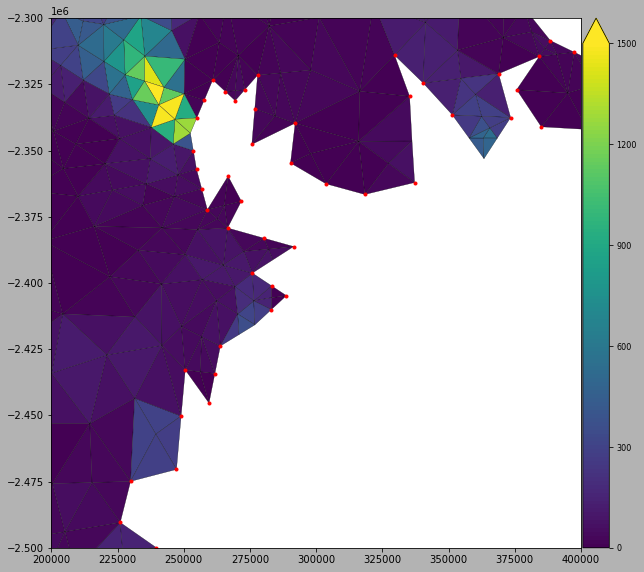

In [11]:
#pos = (md.mesh.vertexonboundary == 1) & (md.geometry.bed > 0)
pos = (md.mesh.vertexonboundary == 1) & (md.initialization.vel < 100)
md.levelset.spclevelset[pos] = -1

fig = plt.figure(figsize=(10,10))
plotmodel(md, 'data', md.initialization.vel, 'caxis', [0, 1500], 'edgecolor', 'k')
pos = np.where(md.levelset.spclevelset == -1)
plt.plot(md.mesh.x[pos], md.mesh.y[pos], 'r.')

plt.xlim(200000,400000)
plt.ylim(-2.5e6, -2.3e6)

In [12]:
md.frontalforcings.thermalforcing[0,0]

10.0

In [13]:
    #Set surface mass balance
    ncdata = Dataset('./Data/Greenland_5km_dev1.2.nc', mode='r')
    x1 = np.squeeze(ncdata.variables['x1'][:].data)
    y1 = np.squeeze(ncdata.variables['y1'][:].data)
    #smb = np.squeeze(ncdata.variables['smb'][:].data)
    ncdata.close()

    if False:
        smb = InterpFromGridToMesh(x1, y1, smb, md.mesh.x, md.mesh.y, 0)
        smb = smb * md.materials.rho_freshwater / md.materials.rho_ice
        smb = np.vstack((smb, smb, smb - 1.0)).T
        md.smb.mass_balance = np.vstack((smb, np.asarray([[1, 10, 20]])))

    with open('./Data/smbbox.npz', "rb") as smbFile:
        SMB = np.load(smbFile)
        x1 = np.squeeze(SMB['x1'])
        y1 = np.squeeze(SMB['y1'])
        smbmean = np.squeeze(SMB['smbmean'])

    #convert mesh x, y into the Box projection
    [md.mesh.lat, md.mesh.long] = xy2ll(md.mesh.x, md.mesh.y, + 1, 39, 71)
    [xi, yi] = ll2xy(md.mesh.lat, md.mesh.long, + 1, 45, 70)

    #Interpolate and set surface mass balance
    x1 = x1.flatten()
    y1 = y1.flatten()
    smbmean = smbmean.flatten()
    index = BamgTriangulate(x1, y1)
    smb_mo = InterpFromMeshToMesh2d(index, x1, y1, smbmean, xi, yi)
    smb = smb_mo * 12 / 1000 * md.materials.rho_freshwater / md.materials.rho_ice
    md.smb.mass_balance = np.append(smb, 1)
    
    #Set transient options, run for 20 years, saving every timestep
    md.timestepping.time_step = 0.2
    md.timestepping.final_time = 5
    md.settings.output_frequency = 1

    #Additional options
    md.inversion.iscontrol = 0
    md.transient.requested_outputs = ['IceVolume', 'TotalSmb', 'SmbMassBalance']
    md.verbose = verbose('solution', True, 'module', True, 'convergence', True)

    #Go solve
    md.verbose.module = False
    md.verbose.solution = True
    md.verbose.convergence = False
    # top 1 number of proc
    md.cluster = generic('name', gethostname(), 'np', 4)
    
    md = solve(md, 'Transient')

checking model consistency
marshalling file SeaRISEgreenland.bin
uploading input file and queueing script
launching solution sequence on remote cluster

Ice-sheet and Sea-level System Model (ISSM) version  4.21
(website: http://issm.jpl.nasa.gov contact: issm@jpl.nasa.gov)

call computational core:
iteration 1/25  time [yr]: 0.20 (time step: 0.20)
   computing smb 
   computing new velocity
   computing slope of levelset function...
   computing calving and undercutting
   Are of basin 0 is 1.88903e+07
   computing new ice front position
   extrapolation of Vx:
   extrapolation of Vy:
   extrapolation of Thickness:
   call computational core:
   looking for icebergs to kill
   computing basal mass balance
   computing mass transport
   call computational core
   updating vertices positions
   computing new grounding line position
   computing transient requested outputs
   saving temporary results
iteration 2/25  time [yr]: 0.40 (time step: 0.20)
   computing smb 
   computing new velo

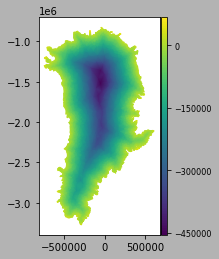

In [141]:
#md.results.TransientSolution

plotmodel(md, "data", md.results.TransientSolution[-1].MaskIceLevelset) #dis

(-2500000.0, -2000000.0)

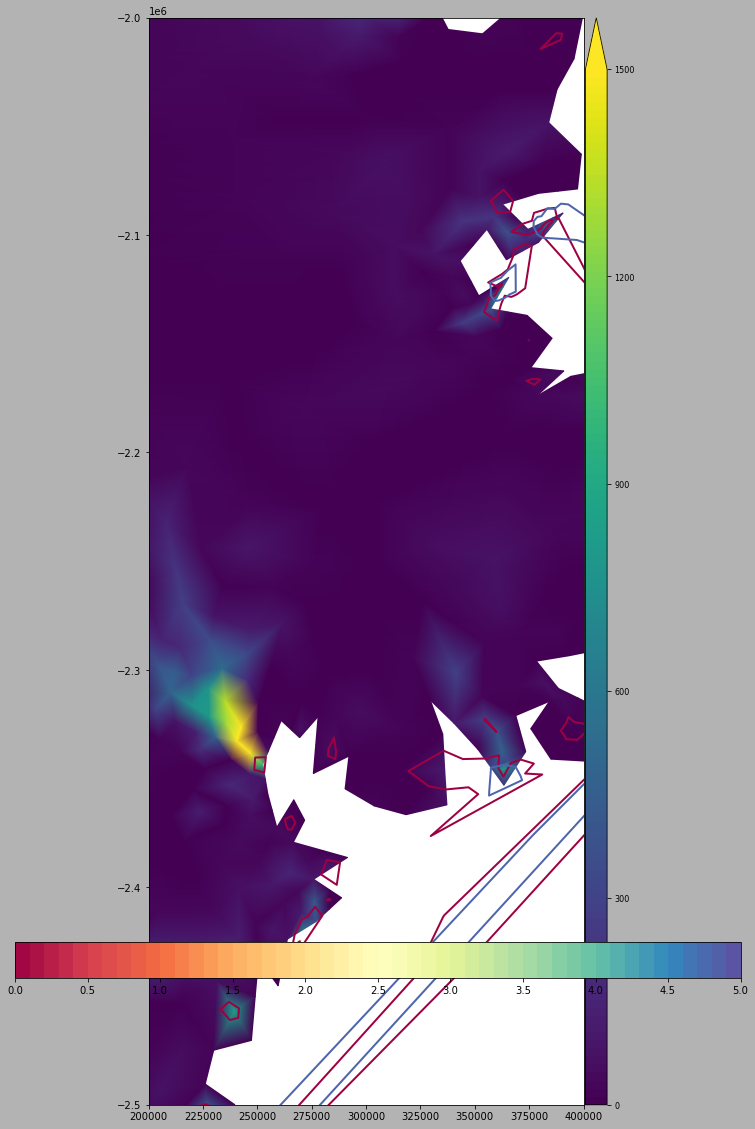

In [175]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
cmap = cmx.get_cmap('Spectral')
 
fig = plt.figure(figsize=(20,20))
#plotmodel(md, 'data', 'mesh')
plotmodel(md, 'data', md.initialization.vel, 'caxis', [0, 1500])
 
# NOTE: The code below plots every 10-th terminus position from md.results.TransientSolution.MaskIceLevelset for speed. This can be changed to every one but will run slightly slower.
n = len(md.results.TransientSolution)
for i in [0, 24]: #range(0,n,10):
    c = cmap(i/n)
    plt.tricontour(md.mesh.x, md.mesh.y, md.results.TransientSolution[i].MaskIceLevelset[:,0], 0, linewidths=2, colors=c)
 
ti = md.timestepping.start_time
tf = md.timestepping.final_time
 
norm = colors.Normalize(vmin=ti,vmax=tf)
sm = cmx.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(ti,tf,11),
             boundaries=np.arange(ti,tf+0.1,.1),
             shrink=0.65, orientation='horizontal')

plt.xlim(200000,400000)
plt.ylim(-2.5e6, -2.0e6)

(-2500000.0, -2000000.0)

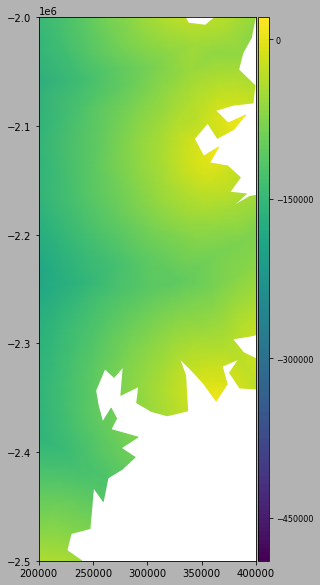

In [14]:
fig = plt.figure(figsize=(10,10))
plotmodel(md, 'data', md.results.TransientSolution[-1].MaskIceLevelset) #, 'caxis', [-1, 1])

plt.xlim(200000,400000)
plt.ylim(-2.5e6, -2.0e6)

   Step 5: Plotting
Opening ./Models/Greenland.Transient.nc for reading 


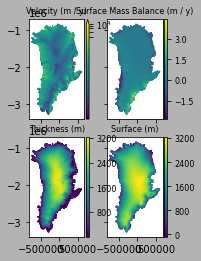

<Figure size 1440x720 with 0 Axes>

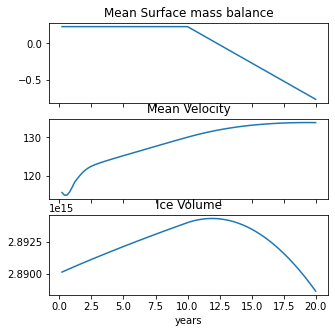

In [16]:
steps = [5]



if 5 in steps:
    #   Step 5: Plotting {{{
    print('   Step 5: Plotting')
    md = loadmodel('./Models/Greenland.Transient.nc')

    #Planview plots
    plotmodel(md, 'data', md.results.TransientSolution[-1].Vel, 'log#1', 1e-1,
              'caxis#1', [1e-1, 1e4], 'title#1', 'Velocity (m / y)',
              'data', md.results.TransientSolution[1].SmbMassBalance,
              'title#2', 'Surface Mass Balance (m / y)',
              'data', md.results.TransientSolution[-1].Thickness,
              'title', 'Thickness (m)',
              'data', md.results.TransientSolution[-1].Surface,
              'title', 'Surface (m)')

    #Line Plots
    #figure
    fig = plt.figure(figsize=(20,10))

    #Plot surface mass balance, velocity and volume
    surfmb = []
    vel = []
    volume = []
    for i in range(0, 100):
        surfmb.append(md.results.TransientSolution[i].SmbMassBalance)
        vel.append(md.results.TransientSolution[i].Vel)
        volume.append(md.results.TransientSolution[i].IceVolume)

    layout, ax = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(5, 5))
    ax[0].plot(np.arange(0.2, 20.2, 0.2), np.nanmean(surfmb, axis=1))
    ax[0].set_title('Mean Surface mass balance')
    ax[1].plot(np.arange(0.2, 20.2, 0.2), np.nanmean(vel, axis=1))
    ax[1].set_title('Mean Velocity')
    ax[2].plot(np.arange(0.2, 20.2, 0.2), volume)
    ax[2].set_title('Ice Volume')
    ax[2].set_xlabel('years')
    # }}}

   Step 6: Extract Box SMB
Opening ./Models/Greenland.Transient.nc for reading 
[[7636.1533   6932.74     6494.1343   ... 5480.8154   6631.505
  7266.2837  ]
 [7404.013    6685.458    6152.54     ... 5327.8867   6472.58
  7025.707   ]
 [6665.149    6166.144    5100.613    ... 4759.784    6105.6494
  6392.682   ]
 ...
 [  94.281624   94.281624   95.4314   ...   94.281624   95.4314
    94.281624]
 [  94.281624   95.4314     94.281624 ...   94.281624   95.4314
    94.281624]
 [  95.4314     94.281624   95.4314   ...   95.4314     94.281624
    95.4314  ]]
2076


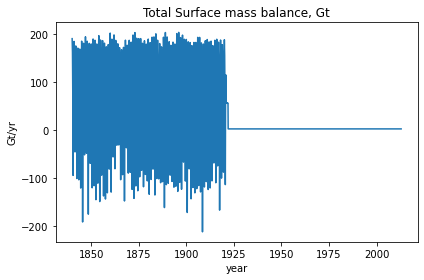

In [17]:
steps = [6]

if 6 in steps:
    #   Step 6: Extract Box SMB{{{
    print('   Step 6: Extract Box SMB')
    md = loadmodel('./Models/Greenland.Transient.nc')

    #Set surface mass balance
    ncbox = Dataset('Data/Box_Greenland_SMB_monthly_1840-2012_5km_cal_ver20141007.nc', mode='r')
    lat = np.squeeze(ncbox.variables['lat'][:].data)
    lon = np.squeeze(ncbox.variables['lon'][:].data)
    smbbox = np.squeeze(ncbox.variables['MassFlux'][:].data)
    ncbox.close()
    [x1, y1] = ll2xy(lat, lon, + 1, 45, 70)

    years_of_simulation = np.arange(1840, 2012 + 1)
    t = np.arange(years_of_simulation[0], years_of_simulation[-1] + 11 / 12, 1 / 12)
    #Area of grid for 5km box
    area_of_grid = 5000 * 5000
    
    print(np.nansum(smbbox / 1000 , axis=(-2, -1)))
    print(len(t))
    totalsmb = np.reshape(np.nansum(smbbox , axis=(-2, -1)), (len(t), 1)) * area_of_grid / 1000
    #save surface mass balance mat dataset
    smbmean = np.nanmean(smbbox, axis=(0, 1))
    SMB = {}
    SMB['smbmean'] = smbmean
    SMB['totalsmb '] = totalsmb
    SMB['smbbox'] = smbbox
    SMB['x1'] = x1
    SMB['y1'] = y1
    SMB['t'] = t

    np.savez('./smbbox.npz', **SMB)

    #plot a time series of total SMB
    fig = plt.figure(tight_layout=True)
    ax = fig.add_subplot(111)
    ax.plot(t, totalsmb / 1e9)
    ax.set_title('Total Surface mass balance, Gt')
    ax.set_xlabel('year')
    ax.set_ylabel('Gt/yr')

    del smbbox
    # }}}

In [18]:
steps = [7]

if 7 in steps:
    #  Step 7: Historical Relaxation run {{{
    print('   Step 7: Historical Relaxation run')
    md = loadmodel('./Models/Greenland.Control_drag.nc')

    with open('./smbbox.npz', "rb") as smbFile:
        SMB = np.load(smbFile)
        x1 = np.squeeze(SMB['x1'])
        y1 = np.squeeze(SMB['y1'])
        smbmean = np.squeeze(SMB['smbmean'])

    #convert mesh x, y into the Box projection
    [md.mesh.lat, md.mesh.long] = xy2ll(md.mesh.x, md.mesh.y, + 1, 39, 71)
    [xi, yi] = ll2xy(md.mesh.lat, md.mesh.long, + 1, 45, 70)

    #Interpolate and set surface mass balance
    x1 = x1.flatten()
    y1 = y1.flatten()
    smbmean = smbmean.flatten()
    index = BamgTriangulate(x1, y1)
    smb_mo = InterpFromMeshToMesh2d(index, x1, y1, smbmean, xi, yi)
    smb = smb_mo * 12 / 1000 * md.materials.rho_freshwater / md.materials.rho_ice
    md.smb.mass_balance = np.append(smb, 1)

    #Set transient options, run for 20 years, saving every timestep
    md.timestepping.time_step = 0.2
    md.timestepping.final_time = 20
    md.settings.output_frequency = 1

    #Additional options
    md.inversion.iscontrol = 0
    md.transient.requested_outputs = ['IceVolume', 'TotalSmb', 'SmbMassBalance']
    md.verbose = verbose('solution', True, 'module', True)

    #Go solve
    md.cluster = generic('name', gethostname(), 'np', 2)
    md = solve(md, 'Transient')

    export_netCDF(md, './Models/Greenland.HistoricTransient.nc')
    # }}}

   Step 7: Historical Relaxation run
Opening ./Models/Greenland.Control_drag.nc for reading 
checking model consistency
marshalling file SeaRISEgreenland.bin
uploading input file and queueing script
launching solution sequence on remote cluster

Ice-sheet and Sea-level System Model (ISSM) version  4.21
(website: http://issm.jpl.nasa.gov contact: issm@jpl.nasa.gov)

   Input updates from constant
   Renumbering degrees of freedom
   Renumbering degrees of freedom
   Renumbering degrees of freedom
   Renumbering degrees of freedom
   Renumbering degrees of freedom
   Renumbering degrees of freedom
call computational core:
iteration 1/100  time [yr]: 0.20 (time step: 0.20)
   computing smb 
   computing new velocity
   Updating constraints and active domain of analysis StressbalanceAnalysis for time: 0.2
   Get solution from inputs
   Reduce vector from g to f set
   Input updates from constant
   Updating inputs from solution for StressbalanceAnalysis
   Allocating matrices (Kff stiffnes

In [19]:


if 8 in steps:
    # Step 8: Plotting exercise {{{
    print('   Step 8: Plotting exercise')
    #Load historic transient model

    #Create Line Plots of relaxation run. Create a figure.

    #Save surface mass balance, by looping through 200 years (1000 steps)
    #Note, the first output will always contain output from time step 1

    #Plot surface mass balance time series in first subplot

    #Title this plot Mean surface mass balance

    #Save velocity by looping through 200 years

    #Plot velocity time series in second subplot

    #Title this plot Mean Velocity

    #Save Ice Volume by looping through 200 years

    #Plot volume time series in third subplot

    #Title this plot Mean Velocity and add an x label of years
    # }}}


In [20]:
steps = [9]

if 9 in steps:
    # Step 9: Box Transient run{{{
    print('   Step 9: Box Transient run')
    md = loadmodel('./Models/Greenland.HistoricTransient.nc')

    #load past transient results
    md.geometry.base = md.results.TransientSolution[-1].Base
    md.geometry.thickness = md.results.TransientSolution[-1].Thickness
    md.geometry.surface = md.geometry.base + md.geometry.thickness
    md.initialization.vx = md.results.TransientSolution[-1].Vx
    md.initialization.vy = md.results.TransientSolution[-1].Vy
    md.results = []

    #convert mesh x, y into the Box projection
    [md.mesh.lat, md.mesh.long] = xy2ll(md.mesh.x, md.mesh.y, + 1, 39, 71)
    [xi, yi] = ll2xy(md.mesh.lat, md.mesh.long, + 1, 45, 70)

    #Set surface mass balance
    with open('./smbbox.npz', "rb") as smbFile:
        SMB = np.load(smbFile)
        x1 = np.squeeze(SMB['x1'])
        y1 = np.squeeze(SMB['y1'])
        smbbox = np.squeeze(SMB['smbbox'])

    x1 = x1.flatten()
    y1 = y1.flatten()
    index = BamgTriangulate(x1, y1)
    #Set years to run
    years_of_simulation = np.arange(2003, 2012 + 1)

    #initialize surface mass balance matrix
    smb = np.nan * np.ones((md.mesh.numberofvertices, len(years_of_simulation) * 12))

    #Interpolate and set surface mass balance
    for year in years_of_simulation:
        for month in range(0, 12):
            smb_mo = griddata((np.double(x1), np.double(y1)), np.double(smbbox[year - 1840, month, :, :].flatten()), (xi, yi), method='nearest')
            smb[:, (year - years_of_simulation[0]) * 12 + month] = smb_mo
    smb = smb * 12 / 1000 * md.materials.rho_freshwater / md.materials.rho_ice
    timer = np.arange(1 / 24, len(years_of_simulation), 1 / 12)
    md.smb.mass_balance = np.vstack((smb, timer))

    #Set transient options, monthly timestep, saving every month
    md.timestepping.time_step = 1 / 12
    md.timestepping.final_time = len(years_of_simulation)
    md.settings.output_frequency = 1

    #Additional options
    md.inversion.iscontrol = 0
    md.transient.requested_outputs = ['IceVolume', 'TotalSmb', 'SmbMassBalance']
    md.verbose = verbose('solution', True, 'module', True)

    #Go solve
    md.cluster = generic('name', gethostname(), 'np', 2)
    md = solve(md, 'Transient')

    export_netCDF(md, './Models/Greenland.BoxTransient.nc')
    # }}}


   Step 9: Box Transient run
Opening ./Models/Greenland.HistoricTransient.nc for reading 
checking model consistency
marshalling file SeaRISEgreenland.bin
uploading input file and queueing script
launching solution sequence on remote cluster

Ice-sheet and Sea-level System Model (ISSM) version  4.21
(website: http://issm.jpl.nasa.gov contact: issm@jpl.nasa.gov)

   Input updates from constant
   Renumbering degrees of freedom
   Renumbering degrees of freedom
   Renumbering degrees of freedom
   Renumbering degrees of freedom
   Renumbering degrees of freedom
   Renumbering degrees of freedom
call computational core:
iteration 1/120  time [yr]: 0.08 (time step: 0.08)
   computing smb 
   computing new velocity
   Updating constraints and active domain of analysis StressbalanceAnalysis for time: 0.0833333
   Get solution from inputs
   Reduce vector from g to f set
   Input updates from constant
   Updating inputs from solution for StressbalanceAnalysis
   Allocating matrices (Kff stiff

   Step 10: Plot Box Transient
Opening ./Models/Greenland.BoxTransient.nc for reading 


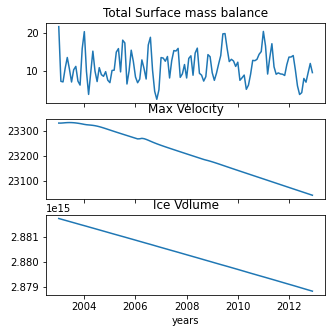

In [21]:
steps = [10]


if 10 in steps:
    print('   Step 10: Plot Box Transient')
    md = loadmodel('./Models/Greenland.BoxTransient.nc')

    #Set years run
    years_of_simulation = np.arange(2003, 2012 + 1)
    t = np.arange(years_of_simulation[0], years_of_simulation[-1] + 11 / 12, 1 / 12)

    #Line Plots
    layout, ax = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(5, 5))
    #Plot surface mass balance
    surfmb = []
    vel = []
    volume = []
    for i in range(0, len(t)):
        surfmb.append(md.results.TransientSolution[i].TotalSmb)
        vel.append(md.results.TransientSolution[i].Vel)
        volume.append(md.results.TransientSolution[i].IceVolume)
    ax[0].plot(t, surfmb)
    ax[0].set_title('Total Surface mass balance')
    ax[1].plot(t, np.nanmax(vel, axis=1))
    ax[1].set_title('Max Velocity')
    ax[2].plot(t, volume)
    ax[2].set_title('Ice Volume')
    ax[2].set_xlabel('years')
